# Install Independences

In [1]:
# FOR SPLITTING DATASET
# Import os to move, modify and create directory for training set and test set
import os
# Import random to generate randomicaly a number
import random
# Import shutil to move the image 
import shutil

# FOR DATA LOADER 
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# FOR AUXILIARY FUNCTION OF NEURAL NETWORK
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2

# FOR MODELS NEURAL NETWORK
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, PReLU
from keras.backend import clear_session, reset_uids
from keras import backend as K
from keras.optimizers import Nadam, Adam, AdamW

# FOR TRAINING 
from keras.utils import plot_model

2024-02-08 19:44:00.225187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 19:44:00.225289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 19:44:00.358017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus =list_physical_devices('GPU')
for gpu in gpus: 
    set_memory_growth(gpu, True)

In [3]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Pre-Processing Data: Splitting

# DataLoader

In [4]:
def data_load(train_dir, validation_dir, image_size, num_batch):
    # Process Data Augmentation
    datagen=ImageDataGenerator(rescale = 1./255,     # Rescaling factor
                               shear_range=0.2,      # Shear Intensity (Shear angle in counter-clockwise direction in degrees) 
                               zoom_range=0.2,       # Range for random zoom.
                               horizontal_flip=True) # Randomly flip inputs horizontally. 
    
    print('------ Loading TRAIN SET -------')
    training_set=datagen.flow_from_directory(train_dir,
                                         target_size=(image_size[0], image_size[1]),
                                         batch_size=num_batch,
                                         class_mode='categorical',
                                         color_mode='rgb')
    
    print('\n\n------ Loading VALIDATION SET ------')
    validation_set=datagen.flow_from_directory(validation_dir,
                                           target_size=(image_size[0], image_size[1]),
                                           batch_size=num_batch,
                                           class_mode='categorical',
                                           color_mode='rgb')
    return training_set, validation_set

# Auxiliary Functions

## Training

In [5]:
def train_model(model, train_set, val_set, early_stopping, pat, num_model, num_epochs):
    # Apply early stop --> to predict overfitting case
    es = None
    if early_stopping == True:
        es = EarlyStopping(monitor='val_loss',
                           mode='min', 
                           patience=pat,
                           restore_best_weights = True,
                           verbose=1
                           )
        # Create a File Pre trained
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[es, ckpt],
                                      epochs = num_epochs)
        
    else:
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[ckpt],
                                      epochs = num_epochs)

    return history, filepath, es

In [6]:
def eval_model(model, train_set , val_set):
    # Evaluate the Model
    metrics_train = model.evaluate(train_set)
    metrics_val = model.evaluate(val_set)

    print("Train Accuracy = %.4f - Train Loss = %.4f" % (metrics_train[1], metrics_train[0]))
    print("Test Accuracy = %.4f - Test Loss = %.4f" % (metrics_val[1], metrics_val[0]))
    
    print("Train F1-Score = %.4f" % (metrics_train[2]))
    print("Train Precision = %.4f" % (metrics_train[3]))
    print("Train Recall = %.4f" % (metrics_train[4]))
    
    print("Test F1-Score = %.4f" % (metrics_val[2]))
    print("Test Precision = %.4f" % (metrics_val[3]))
    print("Test Recall = %.4f" % (metrics_val[4]))

## Evaluation Metrics

In [7]:
# Define Loss Functions
def loss_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Accuracy Function
def accuracy_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['acc'], color='teal', label='accuracy')
    plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define F1 Function
def F1_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['f1_m'], color='teal', label='F1_score')
    plt.plot(hist.history['val_f1_m'], color='orange', label='val_F1_score')
    fig.suptitle('F1 Score', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Precision Function
def precision_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['precision_m'], color='teal', label='precision_score')
    plt.plot(hist.history['val_precision_m'], color='orange', label='val_precision_score')
    fig.suptitle('Precision', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Recall Function
def recall_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['recall_m'], color='teal', label='recall_score')
    plt.plot(hist.history['val_recall_m'], color='orange', label='val_recall_score')
    fig.suptitle('Recall', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()


def plot_history(hist):
    loss_function(hist)
    accuracy_function(hist)
    F1_function(hist)
    precision_function(hist)
    recall_function(hist)

In [8]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Models

## Model 1 - ReLU

In [9]:
#%% ----- MODEL 1 -----
#defining model
def model_1a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

In [10]:
#%% ----- MODEL 1 -----
#defining model
def model_1b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=AdamW(), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

In [11]:
#%% ----- MODEL 1 -----
#defining model
def model_1c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

## Model 2 - PReLU

In [12]:
#%% ----- MODEL 2 -----
#Defining model
def model_2a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [13]:
#%% ----- MODEL 2 -----
#Defining model
def model_2b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = AdamW(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [14]:
#%% ----- MODEL 2 -----
#Defining model
def model_2c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = Nadam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

## Model 3 - GeLU

In [15]:
#%% ----- MODEL 3 -----
#defining model
def model_3a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Adam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [16]:
#%% ----- MODEL 3 -----
#defining model
def model_3b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=AdamW(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [17]:
#%% ----- MODEL 3 -----
#defining model
def model_3c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Nadam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

# Training

## Paths

In [18]:
train_dir = '/kaggle/input/pokemondata/PokemonData/Pokemon_train'
test_dir = '/kaggle/input/pokemondata/PokemonData/Pokemon_validation'

## Training Model 1

In [19]:
img_size1 = (64, 64, 3)
batch_siz1 = 32
num_classes = 151

In [20]:
neuralnetwork_cnn1a = model_1a(img_size1, num_classes= 151)
neuralnetwork_cnn1a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [21]:
neuralnetwork_cnn1b = model_1b(img_size1, num_classes= 151)
neuralnetwork_cnn1b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [22]:
neuralnetwork_cnn1c = model_1c(img_size1, num_classes= 151)
neuralnetwork_cnn1c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [23]:
train_set1 , val_set1 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size1,
                                  num_batch= batch_siz1)

------ Loading TRAIN SET -------
Found 6994 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [24]:
hist1a , fil1a, es1a = train_model(model=neuralnetwork_cnn1a, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=1, 
                                num_epochs= 30) # meglio che arrivi a 30

/tmp/ipykernel_34/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30


I0000 00:00:1707383049.928421      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 [==============================] - ETA: 0s - loss: 4.4831 - acc: 0.1001 - f1_m: 0.0316 - precision_m: 0.2136 - recall_m: 0.0176
Epoch 1: loss improved from inf to 4.48312, saving model to model1.h5
219/219 [==============================] - 81s 352ms/step - loss: 4.4831 - acc: 0.1001 - f1_m: 0.0316 - precision_m: 0.2136 - recall_m: 0.0176 - val_loss: 3.2526 - val_acc: 0.2691 - val_f1_m: 0.1439 - val_precision_m: 0.6492 - val_recall_m: 0.0831
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.9512 - acc: 0.3439 - f1_m: 0.2633 - precision_m: 0.6293 - recall_m: 0.1719
Epoch 2: loss improved from 4.48312 to 2.95124, saving model to model1.h5
219/219 [==============================] - 43s 199ms/step - loss: 2.9512 - acc: 0.3439 - f1_m: 0.2633 - precision_m: 0.6293 - recall_m: 0.1719 - val_loss: 2.3468 - val_acc: 0.4676 - val_f1_m: 0.4304 - val_precision_m: 0.7241 - val_recall_m: 0.3109
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 2.5529 - acc: 0.4491 - f1_m: 0.4326 - precision_m: 0.6360 - recall_m: 0.3314
Epoch 3: loss improved from 2.95124 to 2.55289, saving model to model1.h5
219/219 [==============================] - 43s 198ms/step - loss: 2.5529 - acc: 0.4491 - f1_m: 0.4326 - precision_m: 0.6360 - recall_m: 0.3314 - val_loss: 2.0436 - val_acc: 0.5383 - val_f1_m: 0.5435 - val_precision_m: 0.7603 - val_recall_m: 0.4297
Epoch 4/30
219/219 [==============================] - ETA: 0s - loss: 2.2

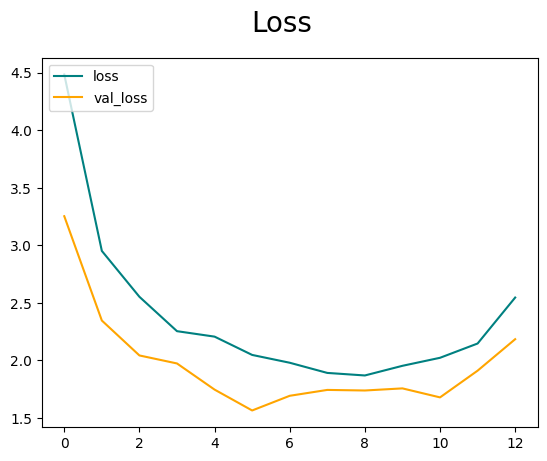

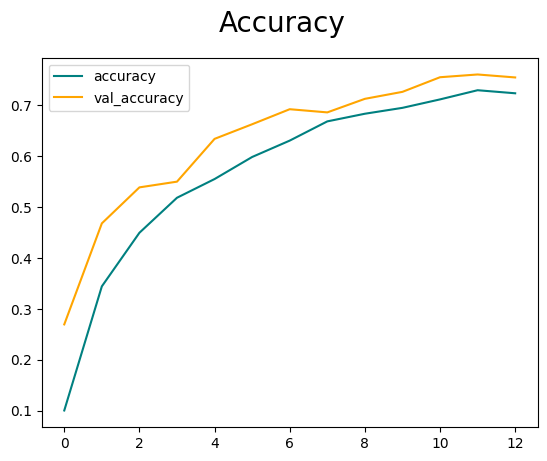

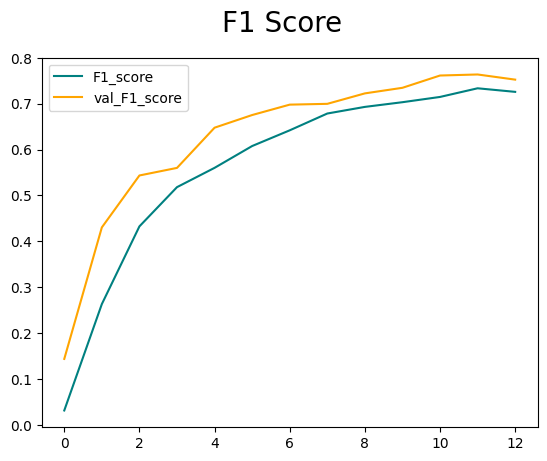

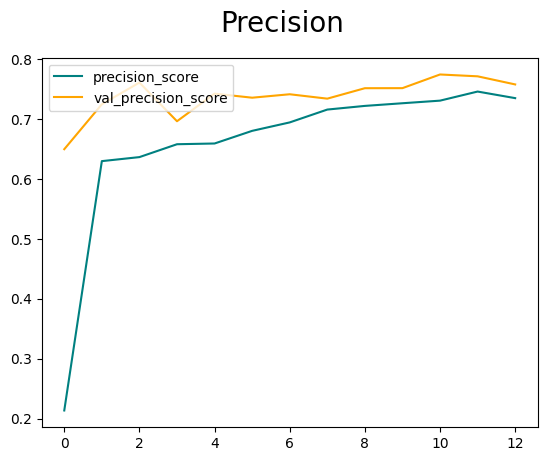

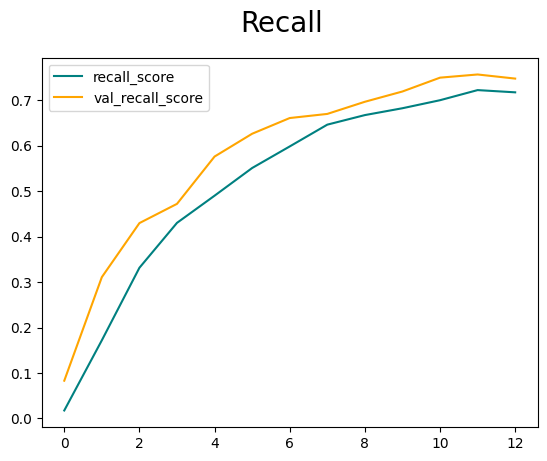

In [25]:
plot_history(hist=hist1a)

In [27]:
hist1b , fil1b, es1b = train_model(model=neuralnetwork_cnn1b, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=2, 
                                num_epochs= 30) # meglio che arrivi a 30

Epoch 1/30


/tmp/ipykernel_34/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 4.0227 - acc: 0.1433 - f1_m: 0.0475 - precision_m: 0.3014 - recall_m: 0.0264
Epoch 1: loss improved from inf to 4.02266, saving model to model2.h5
219/219 [==============================] - 42s 194ms/step - loss: 4.0227 - acc: 0.1433 - f1_m: 0.0475 - precision_m: 0.3014 - recall_m: 0.0264 - val_loss: 2.9564 - val_acc: 0.3290 - val_f1_m: 0.1812 - val_precision_m: 0.7089 - val_recall_m: 0.1065
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 2.8093 - acc: 0.3657 - f1_m: 0.2835 - precision_m: 0.6451 - recall_m: 0.1871
Epoch 2: loss improved from 4.02266 to 2.80925, saving model to model2.h5
219/219 [==============================] - 42s 194ms/step - loss: 2.8093 - acc: 0.3657 - f1_m: 0.2835 - precision_m: 0.6451 - recall_m: 0.1871 - val_loss: 2.2568 - val_acc: 0.4721 - val_f1_m: 0.3891 - val_precision_m: 0.7205 - val_recall_m: 0.2697
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 2.3455 

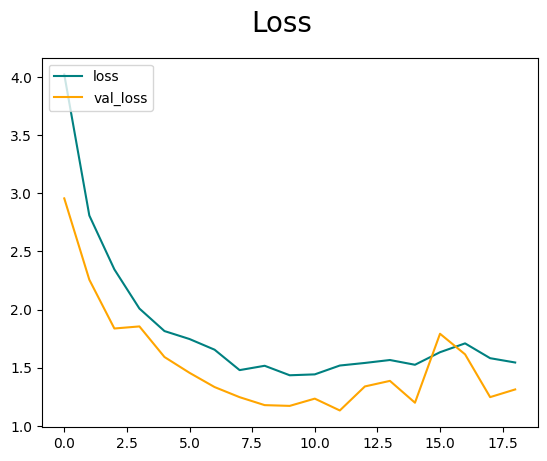

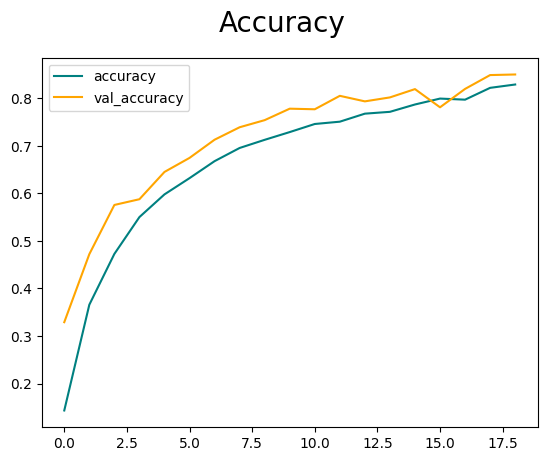

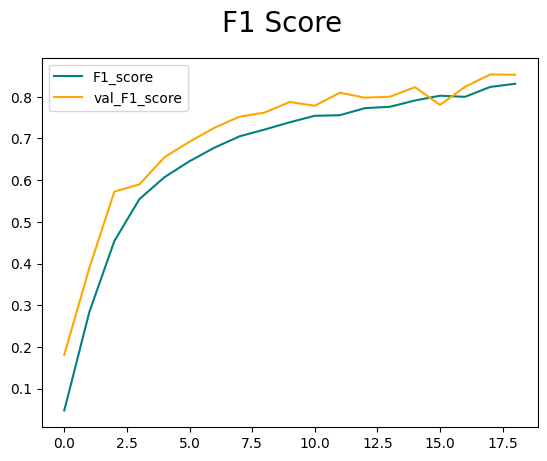

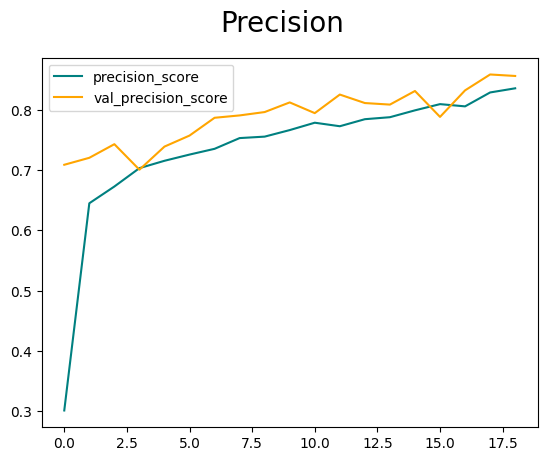

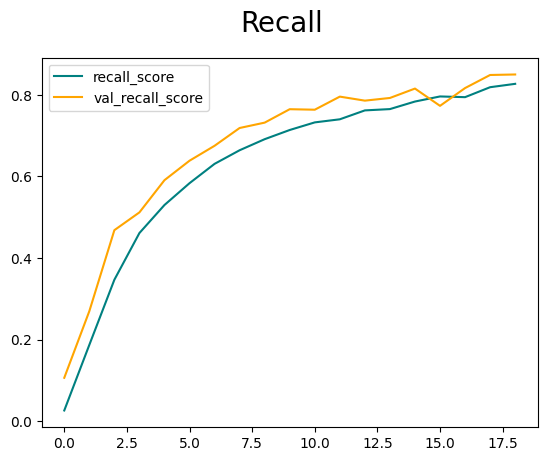

In [28]:
plot_history(hist=hist1b)

In [29]:
hist1c , fil1c, es1c = train_model(model=neuralnetwork_cnn1c, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=1, 
                                num_epochs= 30) # meglio che arrivi a 30

Epoch 1/30


/tmp/ipykernel_34/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 3.8223 - acc: 0.1843 - f1_m: 0.0901 - precision_m: 0.3778 - recall_m: 0.0534
Epoch 1: loss improved from inf to 3.82225, saving model to model1.h5
219/219 [==============================] - 44s 190ms/step - loss: 3.8223 - acc: 0.1843 - f1_m: 0.0901 - precision_m: 0.3778 - recall_m: 0.0534 - val_loss: 2.5899 - val_acc: 0.4085 - val_f1_m: 0.2815 - val_precision_m: 0.7507 - val_recall_m: 0.1760
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 2.6026 - acc: 0.4162 - f1_m: 0.3760 - precision_m: 0.6669 - recall_m: 0.2673
Epoch 2: loss improved from 3.82225 to 2.60262, saving model to model1.h5
219/219 [==============================] - 41s 189ms/step - loss: 2.6026 - acc: 0.4162 - f1_m: 0.3760 - precision_m: 0.6669 - recall_m: 0.2673 - val_loss: 2.0882 - val_acc: 0.5121 - val_f1_m: 0.4813 - val_precision_m: 0.7028 - val_recall_m: 0.3692
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 2.1955 

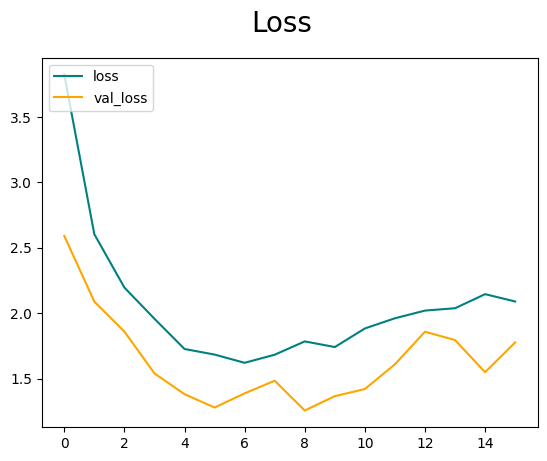

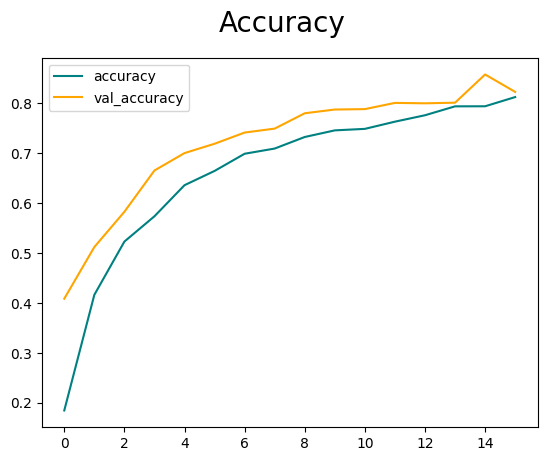

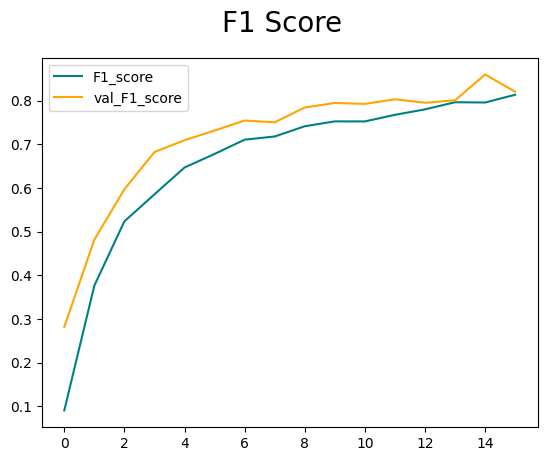

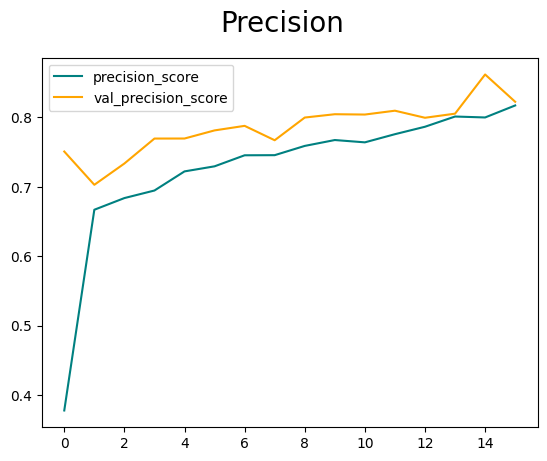

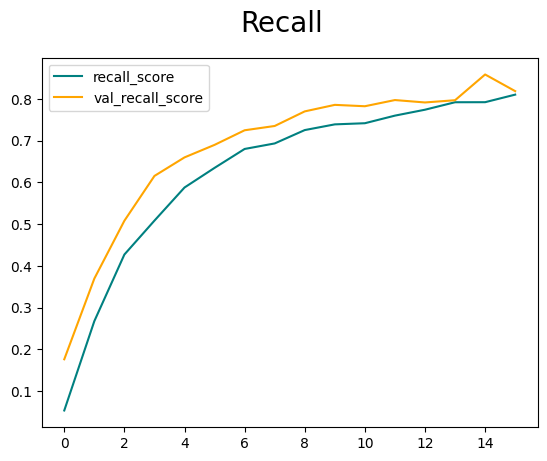

In [30]:
plot_history(hist=hist1c)

## Training Model 2

In [31]:
img_size2 = (64, 64, 3)
batch_siz2 = 32
num_classes = 151

In [32]:
train_set2 , val_set2 = data_load(train_dir = train_dir,
                                validation_dir = test_dir, 
                                image_size=img_size2,
                                num_batch= batch_siz2)

------ Loading TRAIN SET -------
Found 6994 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [33]:
neuralnetwork_cnn2 = model_2a(img_size2, num_classes= 151)
neuralnetwork_cnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

In [34]:
neuralnetwork_cnn2b = model_2b(img_size2, num_classes= 151)
neuralnetwork_cnn2b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

In [35]:
neuralnetwork_cnn2c = model_2c(img_size2, num_classes= 151)
neuralnetwork_cnn2c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

In [37]:
hist2a , fil2a, es2a = train_model(model=neuralnetwork_cnn2, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=4, 
                                num_epochs=30)

/tmp/ipykernel_34/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 4.4356 - acc: 0.0695 - f1_m: 0.0065 - precision_m: 0.0883 - recall_m: 0.0034
Epoch 1: loss improved from inf to 4.43562, saving model to model4.h5
219/219 [==============================] - 52s 229ms/step - loss: 4.4356 - acc: 0.0695 - f1_m: 0.0065 - precision_m: 0.0883 - recall_m: 0.0034 - val_loss: 3.7881 - val_acc: 0.1510 - val_f1_m: 0.0295 - val_precision_m: 0.3235 - val_recall_m: 0.0156
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 3.1798 - acc: 0.2556 - f1_m: 0.1337 - precision_m: 0.6368 - recall_m: 0.0777
Epoch 2: loss improved from 4.43562 to 3.17979, saving model to model4.h5
219/219 [==============================] - 43s 197ms/step - loss: 3.1798 - acc: 0.2556 - f1_m: 0.1337 - precision_m: 0.6368 - recall_m: 0.0777 - val_loss: 2.5495 - val_acc: 0.3864 - val_f1_m: 0.2612 - val_precision_m: 0.7471 - val_recall_m: 0.1628
Epoch 3/30
219/219 [==============================] - ETA: 0s - lo

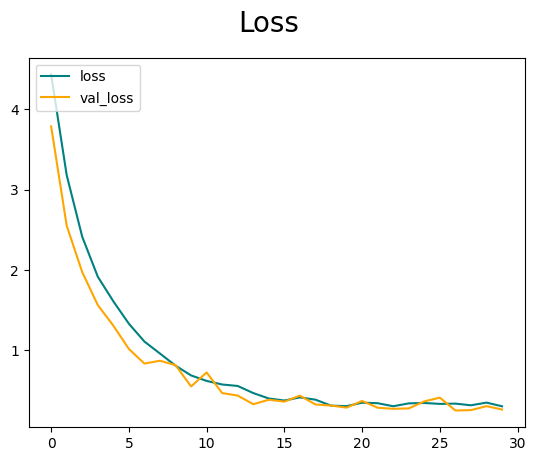

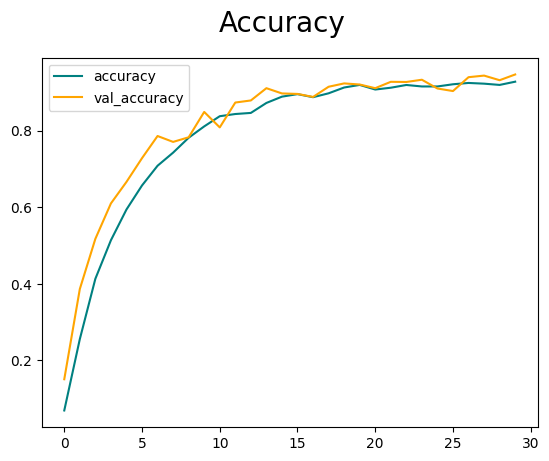

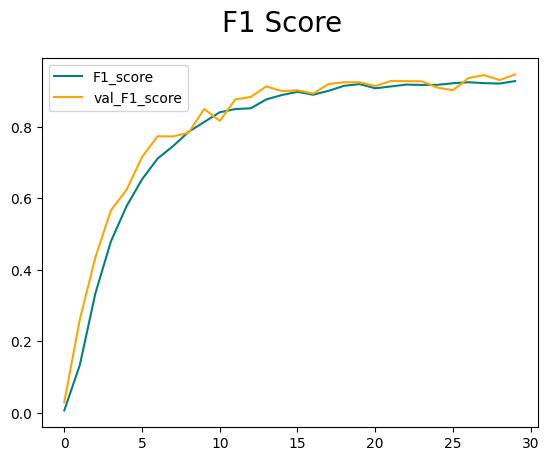

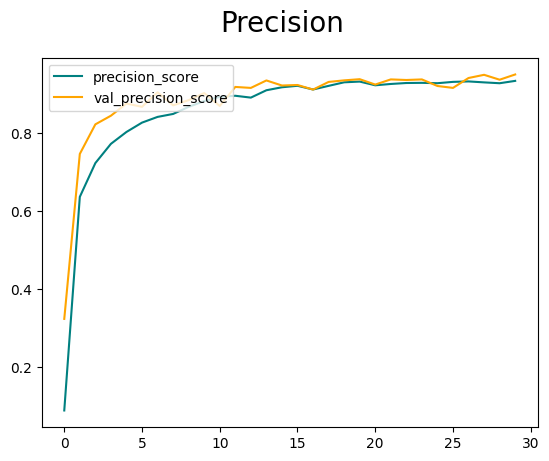

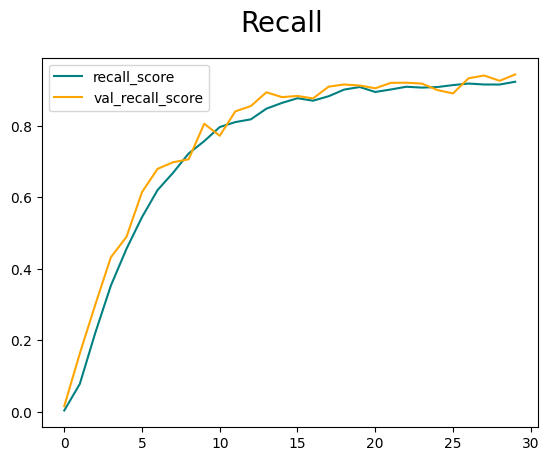

In [38]:
plot_history(hist=hist2a)

In [39]:
hist2b , fil2b, es2b = train_model(model=neuralnetwork_cnn2b, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=22, 
                                num_epochs=30)

/tmp/ipykernel_34/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 4.8430 - acc: 0.0273 - f1_m: 2.7674e-04 - precision_m: 0.0046 - recall_m: 1.4269e-04
Epoch 1: loss improved from inf to 4.84302, saving model to model22.h5
219/219 [==============================] - 44s 194ms/step - loss: 4.8430 - acc: 0.0273 - f1_m: 2.7674e-04 - precision_m: 0.0046 - recall_m: 1.4269e-04 - val_loss: 3.9709 - val_acc: 0.1227 - val_f1_m: 0.0054 - val_precision_m: 0.0614 - val_recall_m: 0.0029
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 3.2502 - acc: 0.2366 - f1_m: 0.1087 - precision_m: 0.5912 - recall_m: 0.0619
Epoch 2: loss improved from 4.84302 to 3.25015, saving model to model22.h5
219/219 [==============================] - 43s 196ms/step - loss: 3.2502 - acc: 0.2366 - f1_m: 0.1087 - precision_m: 0.5912 - recall_m: 0.0619 - val_loss: 2.6713 - val_acc: 0.3436 - val_f1_m: 0.2444 - val_precision_m: 0.7142 - val_recall_m: 0.1501
Epoch 3/30
219/219 [============================

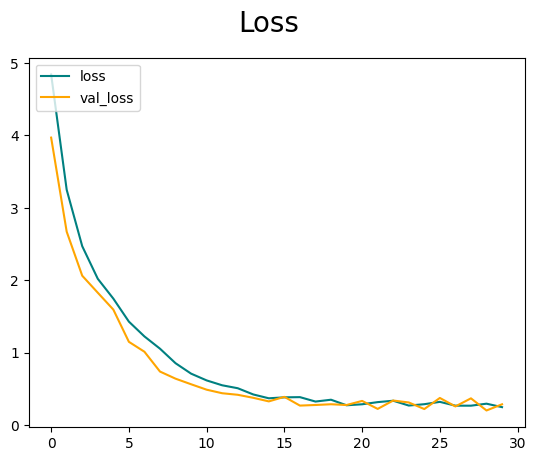

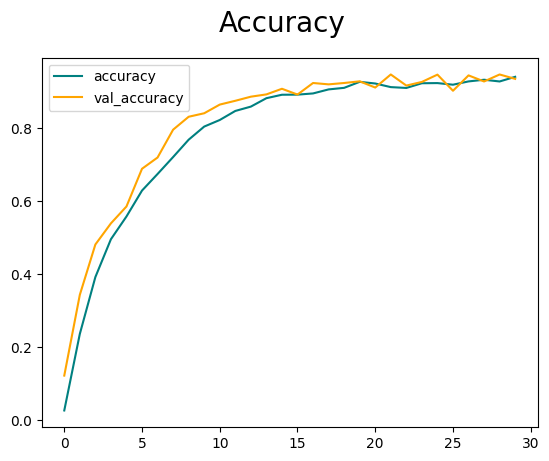

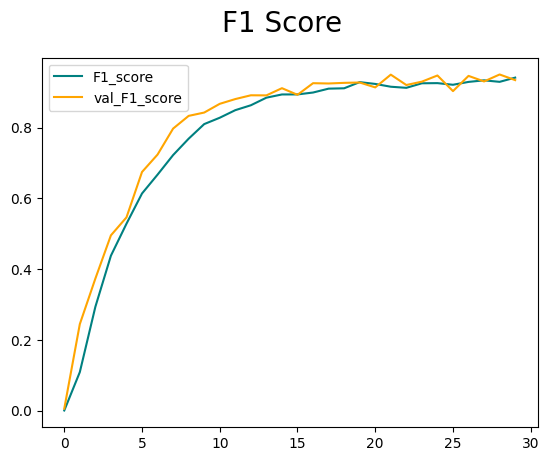

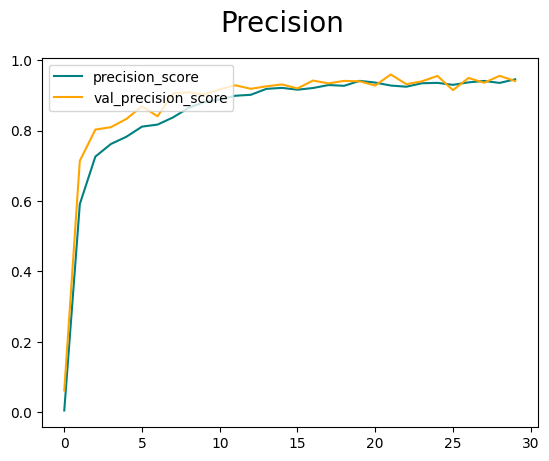

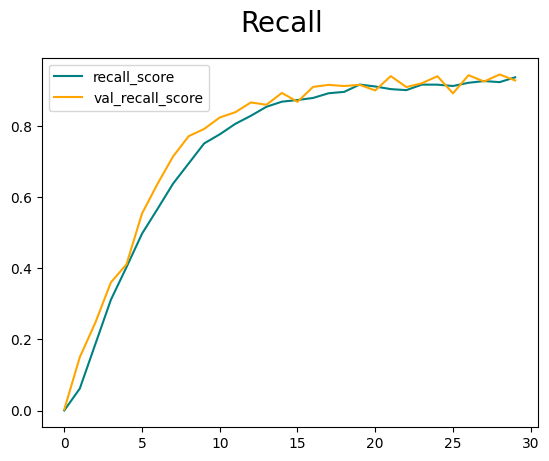

In [40]:
plot_history(hist=hist2b)

In [41]:
hist2c , fil2c, es2c = train_model(model=neuralnetwork_cnn2c, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=23, 
                                num_epochs=30)

/tmp/ipykernel_34/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 3.9855 - acc: 0.1330 - f1_m: 0.0493 - precision_m: 0.3497 - recall_m: 0.0271
Epoch 1: loss improved from inf to 3.98553, saving model to model23.h5
219/219 [==============================] - 56s 247ms/step - loss: 3.9855 - acc: 0.1330 - f1_m: 0.0493 - precision_m: 0.3497 - recall_m: 0.0271 - val_loss: 2.7690 - val_acc: 0.3365 - val_f1_m: 0.1759 - val_precision_m: 0.7769 - val_recall_m: 0.1032
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 2.5567 - acc: 0.3788 - f1_m: 0.2763 - precision_m: 0.7404 - recall_m: 0.1742
Epoch 2: loss improved from 3.98553 to 2.55669, saving model to model23.h5
219/219 [==============================] - 41s 189ms/step - loss: 2.5567 - acc: 0.3788 - f1_m: 0.2763 - precision_m: 0.7404 - recall_m: 0.1742 - val_loss: 2.2213 - val_acc: 0.4364 - val_f1_m: 0.3383 - val_precision_m: 0.8109 - val_recall_m: 0.2175
Epoch 3/30
219/219 [==============================] - ETA: 0s - 

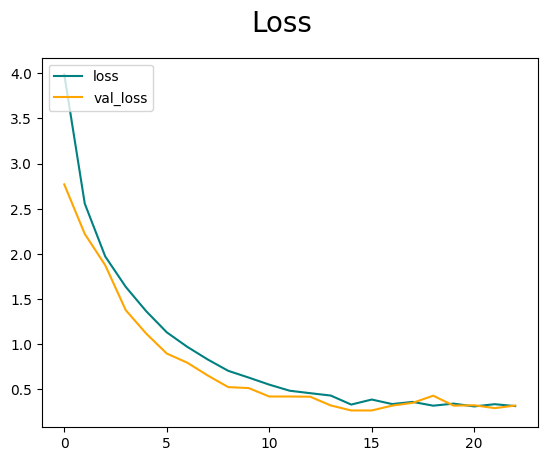

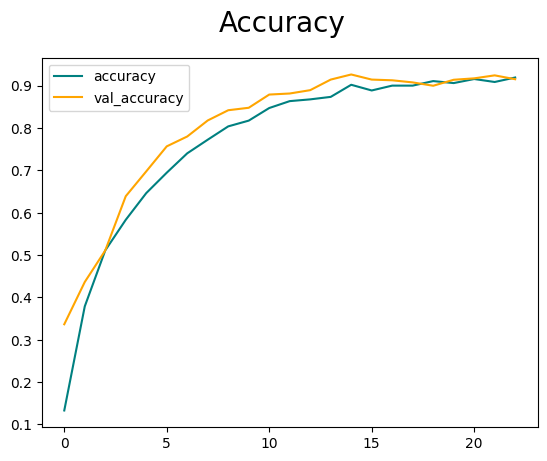

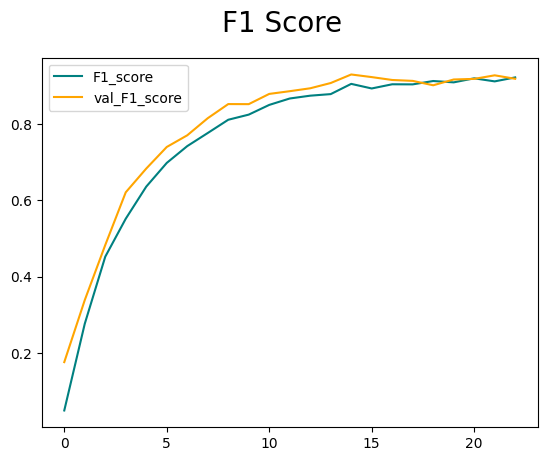

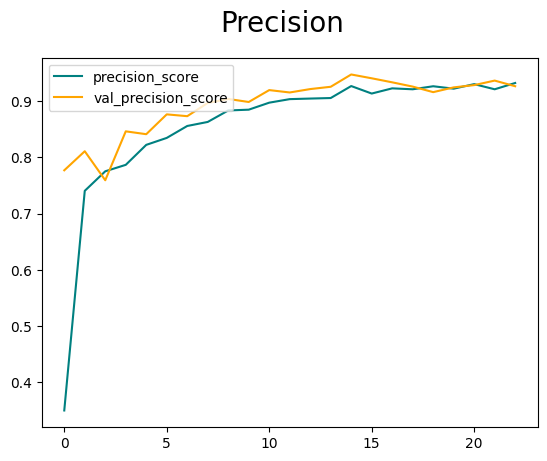

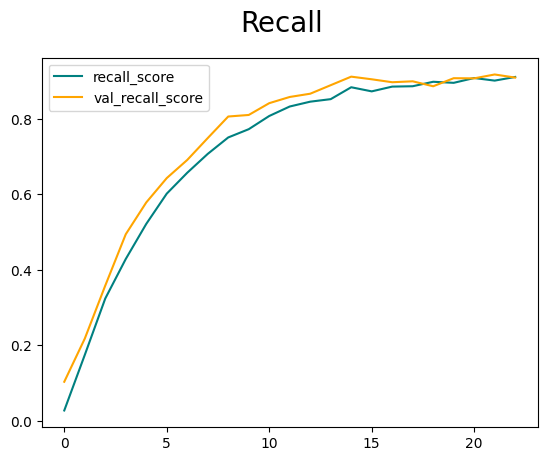

In [42]:
plot_history(hist=hist2c)

## Training Model 3

In [19]:
img_size3= (64, 64, 3)
batch_siz3 = 32
num_classes = 151

In [20]:
neuralnetwork_cnn3a = model_3a(img_size3, num_classes= 151)
neuralnetwork_cnn3a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [21]:
neuralnetwork_cnn3b = model_3b(img_size3, num_classes= 151)
neuralnetwork_cnn3b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [22]:
neuralnetwork_cnn3c = model_3c(img_size3, num_classes= 151)
neuralnetwork_cnn3c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [23]:
train_set3 , val_set3 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size3,
                                  num_batch= batch_siz3)

------ Loading TRAIN SET -------
Found 6994 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [25]:
hist3a , fil3a, es3a = train_model(model=neuralnetwork_cnn3a, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=31, 
                                num_epochs= 30) # meglio che arrivi a 30

/tmp/ipykernel_35/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30


I0000 00:00:1707417948.295547     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 [==============================] - ETA: 0s - loss: 3.8703 - acc: 0.1780 - f1_m: 0.0778 - precision_m: 0.4348 - recall_m: 0.0445
Epoch 1: loss improved from inf to 3.87033, saving model to model31.h5
219/219 [==============================] - 97s 424ms/step - loss: 3.8703 - acc: 0.1780 - f1_m: 0.0778 - precision_m: 0.4348 - recall_m: 0.0445 - val_loss: 2.8524 - val_acc: 0.3565 - val_f1_m: 0.2196 - val_precision_m: 0.7614 - val_recall_m: 0.1316
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.6268 - acc: 0.3973 - f1_m: 0.3255 - precision_m: 0.7169 - recall_m: 0.2147
Epoch 2: loss improved from 3.87033 to 2.62677, saving model to model31.h5
219/219 [==============================] - 46s 210ms/step - loss: 2.6268 - acc: 0.3973 - f1_m: 0.3255 - precision_m: 0.7169 - recall_m: 0.2147 - val_loss: 2.1336 - val_acc: 0.4850 - val_f1_m: 0.4319 - val_precision_m: 0.7727 - val_recall_m: 0.3047
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 2.1201 - acc: 0.5034 - f1_m: 0.4739 - precision_m: 0.7571 - recall_m: 0.3491
Epoch 3: loss improved from 2.62677 to 2.12011, saving model to model31.h5
219/219 [==============================] - 47s 214ms/step - loss: 2.1201 - acc: 0.5034 - f1_m: 0.4739 - precision_m: 0.7571 - recall_m: 0.3491 - val_loss: 1.6942 - val_acc: 0.5953 - val_f1_m: 0.5498 - val_precision_m: 0.8436 - val_recall_m: 0.4124
Epoch 4/30
219/219 [==============================] - ETA: 0s - loss: 1

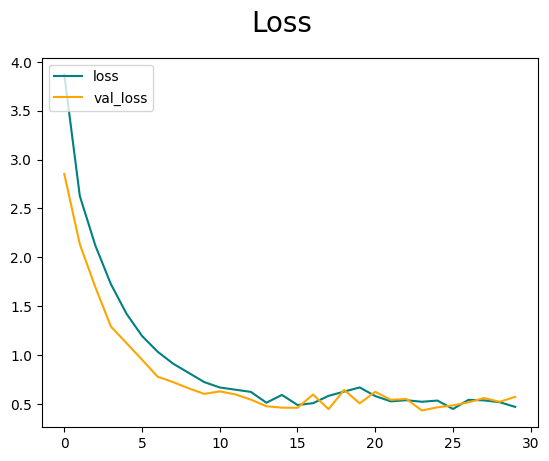

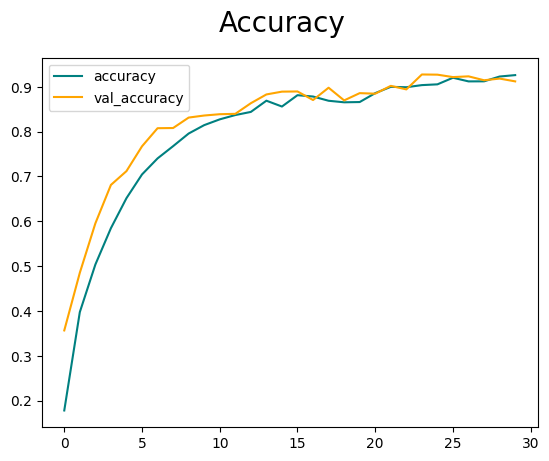

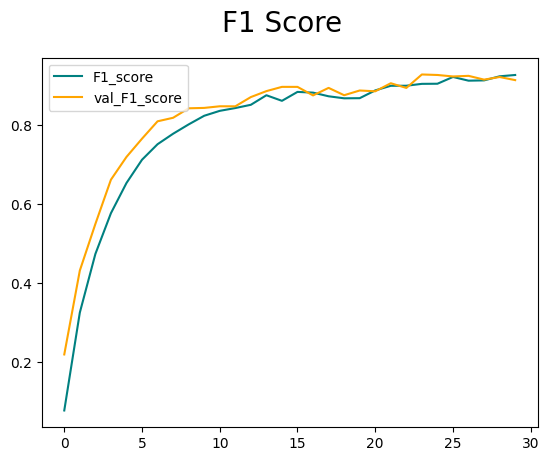

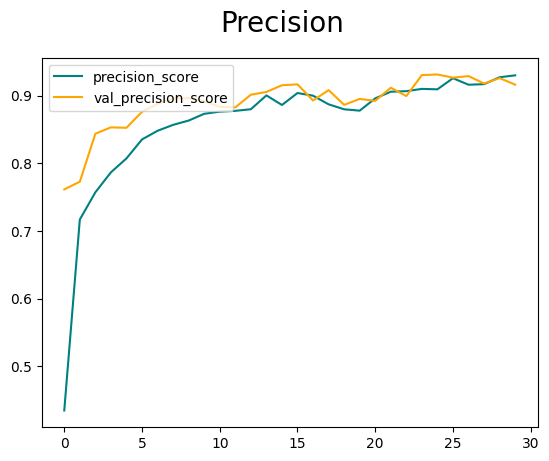

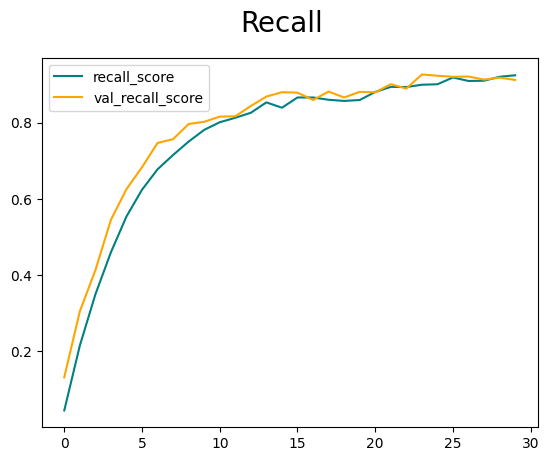

In [26]:
plot_history(hist=hist3a)

In [24]:
hist3b , fil3b, es3b = train_model(model=neuralnetwork_cnn3b, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=32, 
                                num_epochs= 30) # meglio che arrivi a 30

/tmp/ipykernel_34/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30


I0000 00:00:1707421489.570887      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 [==============================] - ETA: 0s - loss: 3.8509 - acc: 0.1820 - f1_m: 0.0836 - precision_m: 0.4349 - recall_m: 0.0480
Epoch 1: loss improved from inf to 3.85086, saving model to model32.h5
219/219 [==============================] - 100s 437ms/step - loss: 3.8509 - acc: 0.1820 - f1_m: 0.0836 - precision_m: 0.4349 - recall_m: 0.0480 - val_loss: 2.6928 - val_acc: 0.3856 - val_f1_m: 0.2617 - val_precision_m: 0.6999 - val_recall_m: 0.1637
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.7107 - acc: 0.3796 - f1_m: 0.3235 - precision_m: 0.7095 - recall_m: 0.2136
Epoch 2: loss improved from 3.85086 to 2.71069, saving model to model32.h5
219/219 [==============================] - 46s 208ms/step - loss: 2.7107 - acc: 0.3796 - f1_m: 0.3235 - precision_m: 0.7095 - recall_m: 0.2136 - val_loss: 2.1479 - val_acc: 0.4963 - val_f1_m: 0.4298 - val_precision_m: 0.8304 - val_recall_m: 0.2940
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 2.1003 - acc: 0.5024 - f1_m: 0.4794 - precision_m: 0.7515 - recall_m: 0.3561
Epoch 3: loss improved from 2.71069 to 2.10033, saving model to model32.h5
219/219 [==============================] - 45s 208ms/step - loss: 2.1003 - acc: 0.5024 - f1_m: 0.4794 - precision_m: 0.7515 - recall_m: 0.3561 - val_loss: 1.7014 - val_acc: 0.5790 - val_f1_m: 0.5472 - val_precision_m: 0.8220 - val_recall_m: 0.4157
Epoch 4/30
219/219 [==============================] - ETA: 0s - loss: 1

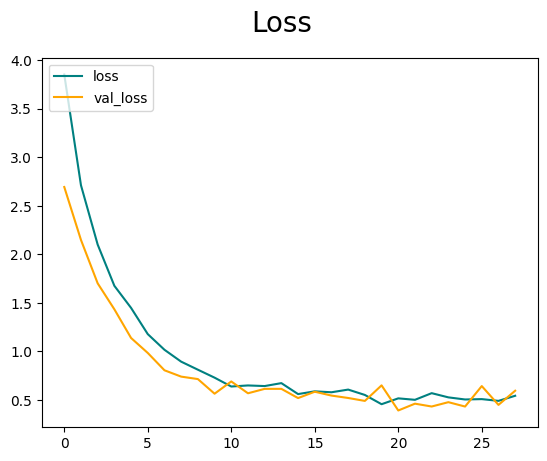

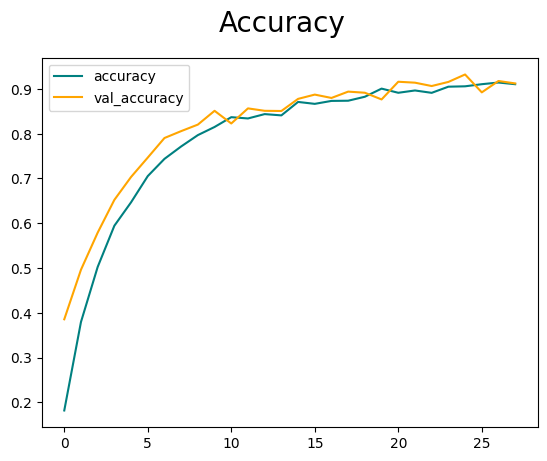

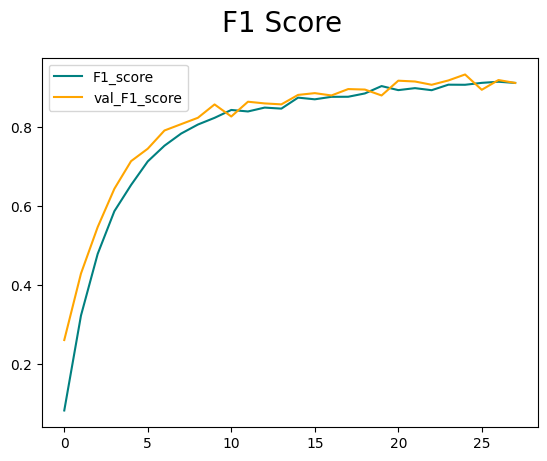

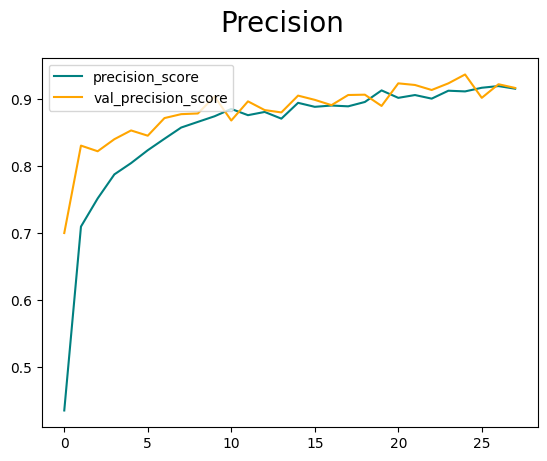

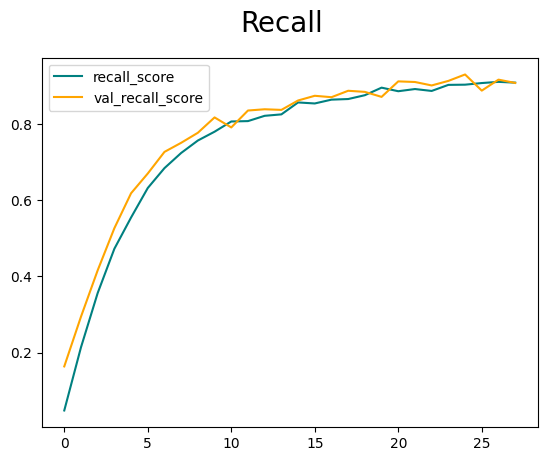

In [25]:
plot_history(hist=hist3b)

In [26]:
hist3c , fil3c, es3c = train_model(model=neuralnetwork_cnn3c, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=33, 
                                num_epochs= 30) # meglio che arrivi a 30

/tmp/ipykernel_34/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 3.7422 - acc: 0.1983 - f1_m: 0.0921 - precision_m: 0.4273 - recall_m: 0.0534
Epoch 1: loss improved from inf to 3.74222, saving model to model33.h5
219/219 [==============================] - 47s 206ms/step - loss: 3.7422 - acc: 0.1983 - f1_m: 0.0921 - precision_m: 0.4273 - recall_m: 0.0534 - val_loss: 2.5695 - val_acc: 0.4114 - val_f1_m: 0.2799 - val_precision_m: 0.7934 - val_recall_m: 0.1727
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 2.4714 - acc: 0.4262 - f1_m: 0.3548 - precision_m: 0.7258 - recall_m: 0.2392
Epoch 2: loss improved from 3.74222 to 2.47136, saving model to model33.h5
219/219 [==============================] - 46s 208ms/step - loss: 2.4714 - acc: 0.4262 - f1_m: 0.3548 - precision_m: 0.7258 - recall_m: 0.2392 - val_loss: 1.8871 - val_acc: 0.5541 - val_f1_m: 0.4964 - val_precision_m: 0.8374 - val_recall_m: 0.3577
Epoch 3/30
219/219 [==============================] - ETA: 0s - 

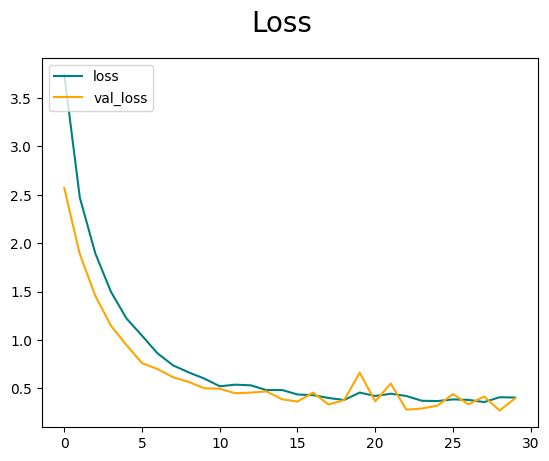

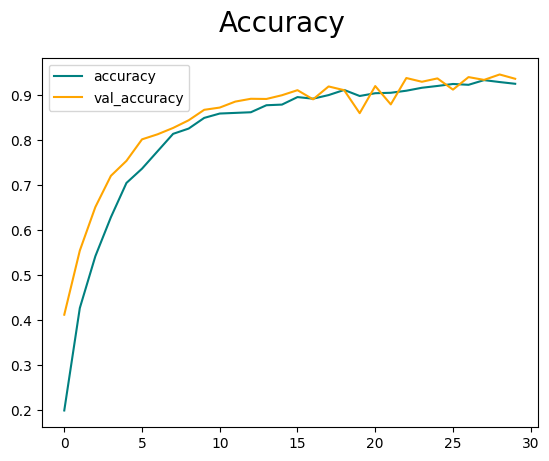

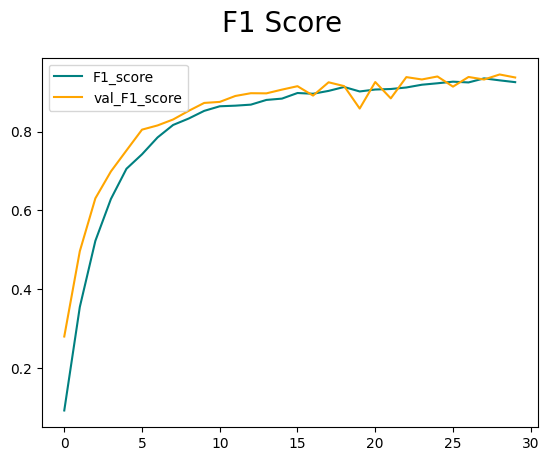

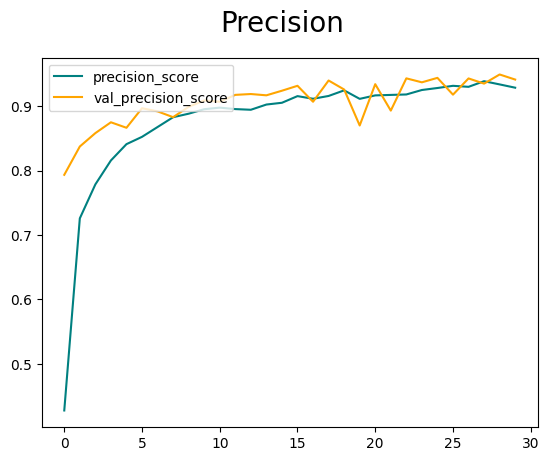

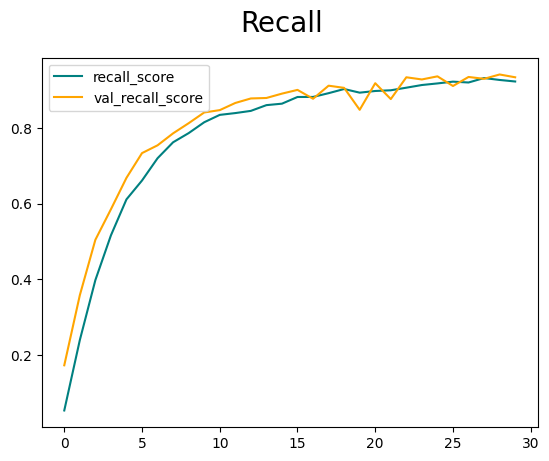

In [27]:
plot_history(hist=hist3c)